# 🧠 True Crime Investigator – AI-Powered Case Summarizer

## 🧩 Problem

True crime cases are often long, complex, and scattered across sources.  
Researchers, students, and the general public often struggle to quickly understand:

- What happened
- Who was involved
- What are the facts vs. public theories
- What misinformation exists

## 🚀 Solution: AI Case Summarizer

We use Google Gemini 2.0 Flash to generate:

- Structured timelines
- Victim/suspect profiles
- Grounded facts from Wikipedia
- JSON-based case files
- An interactive Q&A assistant on top of the data

This turns any case name into a **report-ready document + chatbot**, exportable in 3 formats.


## 🧠 GenAI Capabilities Demonstrated

✅ **Few-shot Prompting** – a detailed JSON-format example (Zodiac Killer) is used to guide output  
✅ **Structured Output / JSON Mode** – prompts enforce JSON output only  
✅ **Grounding** – Wikipedia summary is embedded in prompt as reliable context  
✅ **Agent Logic** – custom flow handles known, fuzzy, and unknown case input  
✅ **Q&A** – a natural language interface answers questions about the generated report  


## 🧪 System Flow

User Input ➡️ [Case Lookup] ➡️ Wikipedia + Prompt ➡️ Gemini ➡️ JSON Report ➡️ Q&A / Export


================== 1. INSTALL DEPENDENCIES ==================

In [18]:
!pip install -q --upgrade google-genai thefuzz[speedup] wikipedia-api gradio fpdf
from kaggle_secrets import UserSecretsClient
GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

from google import genai
import gradio as gr
import wikipediaapi
import json
from thefuzz import process
from fpdf import FPDF
import os

In [19]:
client = genai.Client(api_key=GOOGLE_API_KEY)

### 🧠 Local Case Index (CASE_LIST)

We maintain a curated list of real-world true crime cases to enable:

- ⚡ **Efficient lookup**: Quickly resolve user input without always invoking the LLM
- 🧩 **Smart disambiguation**: Helps match vague inputs via fuzzy logic (e.g. "Jon" → "JonBenét Ramsey")
- 🧠 **Contextual filtering**: Allows country-based or historical filtering if extended
- 🚀 **Fallback logic**: Acts as the first layer before triggering Gemini for unknown queries

This makes the system faster, cheaper, and more reliable — using the LLM only when necessary.


In [20]:
CASE_LIST = [
    # 🇺🇸 United States
    "JonBenét Ramsey", "OJ Simpson", "Adnan Syed", "Ted Bundy", "Jeffrey Dahmer",
    "Zodiac Killer", "BTK Killer", "Laci Peterson", "Chris Watts", "Casey Anthony",
    "Amanda Knox", "Scott Peterson", "Elizabeth Short (Black Dahlia)", "Aileen Wuornos",
    "Gypsy Rose Blanchard", "Jonestown Massacre", "Darlie Routier", "Travis Alexander",
    "Gannon Stauch", "Vanessa Guillen", "The Watcher", "Golden State Killer",
    "D.B. Cooper", "Elliot Rodger", "Richard Ramirez (Night Stalker)", "Susan Powell",

    # 🇬🇧 United Kingdom
    "Madeleine McCann", "Harold Shipman", "Moors Murders", "Stephen Lawrence",
    "Peter Sutcliffe (Yorkshire Ripper)", "Joanna Yeates", "Levi Bellfield",
    "Jill Dando", "Lucy Letby", "Bibaa Henry and Nicole Smallman",

    # 🇮🇳 India
    "Aarushi Talwar", "Nirbhaya Case", "Sheena Bora", "Bhanwari Devi", "Mehboob Alam",
    "Lakhbir Singh murder", "Shraddha Walker", "Murder of Jessica Lal", "Geeta and Sanjay Chopra",
    "Indrani Mukerjea", "Bitta Karate", "Charles Sobhraj",

    # 🇨🇦 Canada
    "Paul Bernardo", "Karla Homolka", "Luka Magnotta", "Reena Virk", "Russell Williams",

    # 🇦🇺 Australia
    "Lindy Chamberlain", "Daniel Morcombe", "Port Arthur Massacre", "Martin Bryant",
    "Anita Cobby", "William Tyrrell", "Kathleen Folbigg",

    # 🇿🇦 South Africa
    "Oscar Pistorius", "Pieter Blom", "Van Breda Murders", "Henri van Breda",

    # 🇯🇵 Japan
    "Junko Furuta", "Setagaya Family Murder", "Tsutomu Miyazaki",

    # 🇨🇳 China
    "Zhao Zhihong", "Gu Kailai", "Gao Chengyong",

    # 🇲🇽 Mexico / LATAM
    "Ciudad Juárez Femicide", "El Pozolero", "Murder of Ingrid Escamilla",

    # 🇷🇺 Russia
    "Andrei Chikatilo", "Alexander Pichushkin", "Bitsevsky Maniac",

    # 🌍 International Famous
    "Charles Manson", "Son of Sam", "Norwegian Massacre – Anders Breivik",
    "Brussels Airport Robbery", "The Hatton Garden Heist", "Kim Wall Murder",
    "Gabby Petito", "Rohinie Bisesar", "Malice Green", "Murder of Meredith Kercher",
    "Murder of Kitty Genovese", "Murder of Bianca Devins", "Murder of Jun Lin"
]


### 🤖 Gemini Suggestions (`suggest_with_gemini`)

If the user’s input doesn’t match any known case,
we query Gemini to generate related true crime case suggestions in JSON format.


In [21]:
def suggest_with_gemini(user_input):
    prompt = f"""
You are an expert in true crime cases. The user typed: "{user_input}"

Please return a list of 3-5 real-world true crime cases that are closely related. Each case should contain:
- full_name: The name of the person involved in the case.
- country: The country where the crime occurred.
- year: The year the crime or incident happened.
- short_reason: A brief summary of why this case is relevant to the user's input.

Format your response as a JSON array. Each element in the array should be a case.

Respond only with JSON. Example:

[
  {{
    "full_name": "Case Name",
    "country": "Country",
    "year": "Year",
    "short_reason": "Brief summary of the case."
  }},
  ...
]
"""
    try:
        # Send request to Gemini model
        response = client.models.generate_content(model="gemini-2.0-flash", contents=prompt)
        
        # Debugging: Print the raw response content to check if it has extraneous data
        print("Raw response:", response.text)
        
        # Strip any unnecessary characters or extra data
        clean_response = response.text.strip()  # Clean the response to remove unwanted whitespace
        
        # Find and extract the JSON part from the response
        start = clean_response.find("[")  # Find the start of the array
        end = clean_response.rfind("]") + 1  # Find the end of the array and include it
        
        if start != -1 and end != -1:
            # Extract the JSON content
            content = clean_response[start:end]
            suggestions = json.loads(content)
            
            # Check for exact match on the full name
            for suggestion in suggestions:
                if suggestion['full_name'].lower() == user_input.lower():
                    return suggestion['full_name']  # If exact match, return only the full name
            
            # If no exact match, return the list of suggestions
            return [suggestion['full_name'] for suggestion in suggestions]
        
        # If no valid JSON found, return an empty list
        print("No valid JSON found in the response.")
        return []
    
    except json.JSONDecodeError as e:
        # Handle JSON decoding errors
        print(f"Error decoding JSON: {e}")
        return []
    except Exception as e:
        # Handle any other exceptions
        print(f"An unexpected error occurred: {e}")
        return []

### 🔎 Smart Lookup (`smart_case_lookup`)

This agent checks the user input in 3 stages:
1. Exact match from local DB
2. Fuzzy match via string similarity
3. Gemini fallback for unknown or vague inputs


In [22]:
def smart_case_lookup(user_input):
    # Exact match first
    matches = [c for c in CASE_LIST if user_input.lower() in c.lower()]
    if matches:
        return matches  # Return exact matches
    
    # If no exact match, perform fuzzy matching
    fuzzy_matches = process.extract(user_input, CASE_LIST, limit=5)
    matches = [m[0] for m in fuzzy_matches if m[1] >= 80]  # Only include matches with score >= 80

    if matches:
        return matches  # Return fuzzy matches
    
    # If no matches were found, return suggestions from Gemini
    return suggest_with_gemini(user_input)

### 🌐 Grounding Layer (`get_wikipedia_summary`)

To anchor Gemini’s output in facts, we pull Wikipedia summaries
for known case names and include them in the prompt context.


In [23]:
def get_wikipedia_summary(query, lang="en", max_chars=1500):
    wiki = wikipediaapi.Wikipedia(language=lang, user_agent="TrueCrimeInvestigatorBot/1.0 (ishanvim05@gmail.com")
    page = wiki.page(query)
    return page.summary[:max_chars] if page.exists() else None

### 🧠 Prompt Constructor (`build_prompt`)

Combines:
- Few-shot examples (Zodiac Killer JSON)
- Grounded knowledge (Wikipedia)
- JSON-only output enforcement

Creates a reliable, controlled prompt for Gemini 2.0 Flash.


In [24]:
def build_prompt(case_name, wiki_summary):
    wiki_block = f"""
Use this Wikipedia summary to guide your report:
\"\"\"{wiki_summary}\"\"\"""" if wiki_summary else "Wikipedia info was not available. Use your own internal knowledge."

    return f"""
You are a world-class true crime AI investigator.
{wiki_block}

🧪 EXAMPLE CASE: "Zodiac Killer"
{{
  "victim_profile": "Several victims, young couples attacked in California (1960s).",
  "survivor_profile": "Some victims survived, gave limited descriptions.",
  "crime_timeline": [{{"date": "1968-12-20", "event": "Lake Herman Road murders"}}],
  "suspects": [{{"name": "Arthur Leigh Allen", "reason": "Strong circumstantial evidence"}}],
  "facts_uncertainties": [{{"fact": "Sent coded messages to press"}}, {{"uncertainty": "Identity never proven"}}],
  "public_theories": [{{"theory": "Worked alone"}}, {{"theory": "Was part of a group"}}],
  "media_coverage": [{{"source": "Zodiac (2007 film)"}}],
  "legal_outcomes": "No charges filed. Case remains open.",
  "impact": "Changed law enforcement's approach to serial killers.",
  "references": [{{"source": "Wikipedia", "url": "https://en.wikipedia.org/wiki/Zodiac_Killer"}}]
}}

Generate a similarly detailed JSON report on: "{case_name}"

Return only valid JSON.
"""

### 🕹️ Decision Agent (`agent_decision_flow`)

Analyzes smart lookup results and:
- Confirms if input is valid
- Requests clarification or suggestions otherwise


In [25]:
def agent_decision_flow(user_input):
    matches = smart_case_lookup(user_input)

    # If we found matches (either exact or fuzzy), return them
    if matches:
        return False, matches  # Return a list of possible cases for the user to clarify
    
    # If no matches are found, return a message saying no results were found
    return False, ["No relevant cases found. Please try searching for a different case or keyword."]

### 📄 Report Generator (`generate_summary`)

Sends the prompt to Gemini 2.0 Flash and parses the returned JSON structure
containing timeline, suspects, theories, and more.


In [26]:
def generate_summary(case_name):
  wiki_data = get_wikipedia_summary(case_name)
  prompt = build_prompt(case_name, wiki_data)
  try:

    response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=prompt)
    content = response.text
    print(content)
    start, end = content.find("{"), content.rfind("}") + 1
    return json.loads(content[start:end])
  except:
        return {}

### 📜 Markdown Renderer (`render_summary`)

Takes structured JSON and formats it into readable markdown.
Used for visualizing reports inside Gradio or notebooks.


In [27]:


def render_summary(summary, case_name):
    if not summary:
        return f"❌ No summary could be generated for: {case_name}"

    md = f"# 🧠 True Crime Case Report: **{case_name}**\n\n"

    # Create sections for each part of the case report
    def section(title, data):
        nonlocal md
        md += f"## 🔹 {title}\n"
        if isinstance(data, list):
            for i in data:
                if isinstance(i, dict):
                    for k, v in i.items():
                        md += f"- **{k}**: {v}\n"
                else:
                    md += f"- {i}\n"
        else:
            md += f"- {data}\n"
        md += "\n"

    for key in [
        "victim_profile", "survivor_profile", "crime_timeline", "suspects",
        "facts_uncertainties", "public_theories", "media_coverage",
        "legal_outcomes", "impact", "references"
    ]:
        if key in summary:
            section(key.replace("_", " ").title(), summary[key])

    return md

### 🧩 Master Controller (`gradio_agent`)

Ties everything together:
- Handles user input
- Gets case
- Runs report
- Stores session memory
- Returns rendered summary

In [34]:
def gradio_agent(user_input):
    # Call the smart_case_lookup function to get either a match or a list of suggestions
    result = smart_case_lookup(user_input)

    # If the result is a single case name (exact match in the CASE_LIST)
    if isinstance(result, str):  # Single case name (exact match)
      print("here")
      case_name = result
      summary = generate_summary(case_name)  # Fetch the summary for the specific case
      rendered = render_summary(summary, case_name)  # Render the summary
        # Save to memory (max 3)
      search_memory.append((case_name, rendered))
      if len(search_memory) > 3:
          search_memory.pop(0)
        # Return detailed report for the match below, not in status bar
          return f"✅ Report generated for: {case_name}", rendered, (summary, case_name), "\n".join([f"- {case[0]}" for case in search_memory])

    # If the result is a list (fuzzy matches or Gemini suggestions)
    elif isinstance(result, list):
        if len(result) == 1:
            # If only one match found, handle it like an exact match
            case_name = result[0]
            summary = generate_summary(case_name)  # Fetch the summary for the case
            rendered = render_summary(summary, case_name)  # Render the summary
            # Save to memory (max 3)
            search_memory.append((case_name, rendered))
            if len(search_memory) > 3:
                search_memory.pop(0)
            # Return detailed report for the match below, not in the status bar
            return f"✅ Report generated for: {case_name}", rendered, (summary, case_name), "\n".join([f"- {case[0]}" for case in search_memory])

        else:
            # If multiple matches found, show a list of suggestions in the status box
            return "Case not found , maybe you were reffering to:-","\n".join([f"- {r}" for r in result]), "", None, ""

    # If no matches are found, return a generic message in the status bar
    return "🤔 No matching cases found, please try again with a more specific query.", "", None, ""


### 📤 Export Module (`export_summary`)

Saves structured summaries to:
- `.json` for integration
- `.txt` for readable files
- `.pdf` for presentation


In [29]:
def export_summary(data, file_type):
    # Ensure data is a tuple with 2 elements (summary, case_name)
    print(f"Received data for export: {data}")
    
    if not isinstance(data, tuple) or len(data) != 2:
        raise ValueError("Data must be a tuple containing (summary, case_name).")
    
    summary, case_name = data
    
    # Make sure output directory exists
    output_dir = "exports"
    os.makedirs(output_dir, exist_ok=True)

    # Export as JSON
    if file_type == "json":
        json_data = {
            "case_name": case_name,
            "summary": summary
        }
        # File name with safe characters (no spaces)
        json_filename = os.path.join(output_dir, f"{case_name.replace(' ', '_')}_summary.json")
        try:
            with open(json_filename, 'w') as json_file:
                json.dump(json_data, json_file, indent=4)
            return json_filename  # Return the file path to Gradio
        except Exception as e:
            print(f"Error exporting JSON: {e}")
            return "Error: Could not generate JSON file."

    # Export as TXT
    elif file_type == "txt":
        txt_filename = os.path.join(output_dir, f"{case_name.replace(' ', '_')}_summary.txt")
        try:
            with open(txt_filename, 'w') as txt_file:
                txt_file.write(f"Case Name: {case_name}\n\nSummary:\n{summary}")
            return txt_filename  # Return the file path to Gradio
        except Exception as e:
            print(f"Error exporting TXT: {e}")
            return "Error: Could not generate TXT file."

    # Export as PDF
    elif file_type == "pdf":
        pdf_filename = os.path.join(output_dir, f"{case_name.replace(' ', '_')}_summary.pdf")
        try:
            pdf = FPDF()
            pdf.add_page()
            pdf.set_auto_page_break(auto=True, margin=15)
            pdf.set_font("Arial", size=12)
            pdf.cell(200, 10, txt=f"Case Name: {case_name}", ln=True, align="C")
            pdf.ln(10)  # Add a line break
            pdf.multi_cell(0, 10, txt=f"Summary:\n{summary}")
            pdf.output(pdf_filename)
            return pdf_filename  # Return the file path to Gradio
        except Exception as e:
            print(f"Error exporting PDF: {e}")
            return "Error: Could not generate PDF file."

    # If file type is unknown
    raise ValueError(f"Unsupported file type: {file_type}")
# Example of how the Gradio app is structured


### 💬 Question Answering (`case_qna`)

Enables users to ask questions like:
- Who were the suspects?
- What’s the timeline?
- Were there any theories?

Gemini answers using only the JSON summary as source.


In [30]:
def case_qna(question, report_data):
    if not report_data or not isinstance(report_data, tuple):
        return "No report found. Please generate one first."

    summary, case_name = report_data
    if not summary:
        return "No case data available."

    # Build the context from JSON
    context = json.dumps(summary, indent=2)
    prompt = f"""
You are a helpful assistant answering questions about a true crime case.

ONLY use the data below to answer:
\"\"\"{context}\"\"\"

Q: {question}
A:"""

    try:
        response = client.models.generate_content(
            model="gemini-2.0-flash",
            contents=prompt
        )
        return response.text.strip()
    except Exception as e:
        return f"Error while answering: {e}"


In [31]:
search_memory=[]#to store previous promts for context

In [17]:
CASE_GENRES = {
    "Serial Killers": [
        "Ted Bundy", "Jeffrey Dahmer", "Richard Ramirez", "John Wayne Gacy",
        "Aileen Wuornos", "Gary Ridgway", "Ed Gein", "David Berkowitz",
        "Albert Fish", "Jack the Ripper", "Dennis Rader (BTK Killer)", "Carl Eugene Watts"
    ],
    "Unsolved Mysteries": [
        "Zodiac Killer", "D.B. Cooper", "The Watcher", "The Black Dahlia",
        "The Disappearance of Malaysia Airlines Flight 370", "The Somerton Man",
        "The Hinterkaifeck Murders", "The Isdal Woman", "The Villisca Axe Murders",
        "The Lead Mask Case", "The Beaumont Children", "The YOGTZE Case"
    ],
    "Mass Murders": [
        "Port Arthur Massacre", "Norwegian Massacre – Anders Breivik", "Jonestown Massacre",
        "Sandy Hook Elementary School Shooting", "Columbine High School Shooting",
        "Virginia Tech Shooting", "Las Vegas Shooting (Route 91 Harvest Festival)",
        "The St. Valentine's Day Massacre", "Pulse Nightclub Shooting",
        "Oklahoma City Bombing", "Belsen Massacre", "The Charleston Church Shooting"
    ],
    "Heists and Robberies": [
        "The Great Train Robbery (1963)", "The Antwerp Diamond Heist", "The Banco Central Burglary",
        "The Isabella Stewart Gardner Museum Heist", "The Lufthansa Heist", "The Banco Rio Heist",
        "The Hatton Garden Heist", "The Great Brinks Job", "The Pink Panther Heist",
        "The Spaghetti Bandit", "The Securitas Depot Robbery"
    ],
    "Fraud and Scams": [
        "Bernie Madoff Ponzi Scheme", "Elizabeth Holmes – Theranos Scandal",
        "Frank Abagnale (Catch Me If You Can)", "The Enron Scandal",
        "The Fyre Festival", "The Lehman Brothers Collapse", "Tommy Wiseau (The Room Scandal)",
        "The Turing Pharmaceuticals Price-Gouging", "The Volkswagen Emissions Scandal",
        "The Nigerian Email Scam", "Anna Sorokin (Fake Heiress)"
    ],
    "Cult Crimes": [
        "Charles Manson and the Manson Family", "Jonestown Massacre", "Heaven's Gate",
        "Branch Davidians (Waco Siege)", "The People's Temple", "NXIVM",
        "The Order of the Solar Temple", "The Children of God (Family International)",
        "Raelian Movement", "Aum Shinrikyo", "The Ant Hill Kids"
    ],
    "Domestic Murders": [
        "The O.J. Simpson Case", "The Chris Watts Family Murder", "The Laci Peterson Murder",
        "The JonBenét Ramsey Case", "The Scott Peterson Case", "The Casey Anthony Case",
        "The Jodi Arias Case", "The Black Dahlia (Elizabeth Short)", "The Murder of Reeva Steenkamp (Oscar Pistorius)",
        "The Andrea Yates Murders", "The Mary Bell Murders"
    ],
    "Wrongful Convictions": [
        "The Central Park Five", "Steven Avery (Making a Murderer)", "The West Memphis Three",
        "Richard Phillips", "The Innocence Project Cases", "Kerry Max Cook",
        "Cameron Todd Willingham", "The Georgia Death Row Four", "The case of Curtis Adams",
        "The case of David McCallum", "The case of Thomas Haynesworth"
    ],
    "Crime in High Society": [
        "The Murder of Gianni Versace", "The Stanford Prison Experiment", "The Vanderbilt Murder",
        "The Murder of John Lennon", "The O.J. Simpson Case", "The Clinton–Lewinsky Scandal",
        "The Epstein Scandal", "The Killing of Gianni Versace", "The Murder of Marilyn Monroe",
        "The Bernie Madoff Ponzi Scheme", "The Rebekah Brooks Scandal"
    ],
    "Political and Government Corruption": [
        "Watergate Scandal", "The Iran-Contra Affair", "The Teapot Dome Scandal",
        "The Jeffrey Epstein Scandal", "The Black Sox Scandal", "The United Fruit Company and the CIA",
        "The Panama Papers", "Operation Car Wash (Brazil)", "The China Gate Scandal",
        "The Cash-for-Votes Scandal in India", "The Abscam Scandal"
    ]
}


## 🖥️ Gradio Interface & UX Design

This project includes a **clean and user-friendly Gradio interface**, which allows non-technical users to:

- 🔍 Enter a crime name or keyword
- 🧠 Automatically resolve and match to real-world cases
- 📄 Generate structured, AI-powered summaries
- 💬 Interact with the report via natural language Q&A
- 📁 Export reports to `.json`, `.txt`, or `.pdf` formats
- 🧠 View memory of the last 3 queried cases for context

The design focuses on:
- **Clarity**: All outputs are clearly structured and sectioned
- **Minimal interaction**: 1-click generation, 1-click export
- **Session memory**: Helps users navigate and compare multiple cases
- **Accessibility**: Designed to work in Kaggle, Colab, or Gradio Cloud with zero setup

Gradio makes it simple to showcase complex GenAI capabilities with a smooth user experience — all directly in the notebook.


In [35]:
import gradio as gr

# Assuming you already have CASE_GENRES and other relevant functions

# Define the Gradio interface
with gr.Blocks(theme=gr.themes.Soft()) as app:
    # Main page (first tab)
    with gr.Tab("Home"):
        gr.Markdown("## 🕵️ True Crime Investigator AI – Capstone Project")
        gr.Markdown("Enter a case name, keyword, or crime type to generate a detailed AI report.")

        # Input box to search by case
        with gr.Row():
            input_box = gr.Textbox(label="Enter Case", placeholder="Try: JonBenét, Watcher, Aarushi Talwar")
            run_btn = gr.Button("Investigate 🔍")

        # Status box shows suggestions or fuzzy matches
        status_box = gr.Textbox(label="Status", interactive=False)

        # Output section for detailed case summary
        output_md = gr.Markdown()

        # New memory and export controls
        file_output = gr.File(label="Exported File")
        session_memory = gr.Markdown(label="🧠 Last 3 Searched Cases")

        with gr.Row():
            export_json = gr.Button("⬇️ Export JSON")
            export_txt = gr.Button("📝 Export Text")
            export_pdf = gr.Button("📄 Export PDF")

        # Trigger generation for case lookup
        gen_data = gr.State()  # stores (summary, case_name)
        run_btn.click(fn=gradio_agent, inputs=input_box, outputs=[status_box, output_md, gen_data, session_memory])

        # Export handlers
        export_json.click(fn=lambda d: export_summary(d, "json"), inputs=gen_data, outputs=file_output)
        export_txt.click(fn=lambda d: export_summary(d, "txt"), inputs=gen_data, outputs=file_output)
        export_pdf.click(fn=lambda d: export_summary(d, "pdf"), inputs=gen_data, outputs=file_output)

        # Add question answering functionality
        q_input = gr.Textbox(label="❓ Ask a question about the current case")
        q_button = gr.Button("Ask")
        q_output = gr.Textbox(label="💬 Answer", lines=5)
        q_button.click(fn=case_qna, inputs=[q_input, gen_data], outputs=q_output)

    # "Read More" section (second tab)
    with gr.Tab("Read More"):
        gr.Markdown("## 📚 Explore More True Crime Cases")

        # Genre selection and case listing
        with gr.Row():
            genre_select = gr.Dropdown(label="Select Genre", choices=list(CASE_GENRES.keys()), type="index")
            case_list = gr.Textbox(label="Cases in this Genre", interactive=False, lines=5)

        # When genre changes, display cases of the selected genre
        genre_select.change(
            fn=lambda genre_index: "\n".join(CASE_GENRES[list(CASE_GENRES.keys())[genre_index]]),
            inputs=genre_select, outputs=case_list)

        # Handle case name clicks by creating clickable buttons for each case
        case_buttons = []

        def on_case_click(case_name):
            # Update the input box with the selected case name
            input_box.update(value=case_name)
            # Trigger the investigation button click to generate the case summary
            run_btn.click(fn=gradio_agent, inputs=input_box, outputs=[status_box, output_md, gen_data, session_memory])

        def create_case_buttons(case_list_text):
            # Get cases from the case list text, split by newlines
            cases = case_list_text.split("\n")
            # Create a button for each case
            return [gr.Button(case, on_click=lambda case=case: on_case_click(case)) for case in cases]

        # Update the list of case buttons dynamically based on the genre selection
        case_list.change(fn=create_case_buttons, inputs=case_list, outputs=case_buttons)

app.launch(share=True)


* Running on local URL:  http://127.0.0.1:7863
* Running on public URL: https://6b484fa2f50603696d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Raw response: ```json
[
  {
    "full_name": "Martha Wise",
    "country": "USA",
    "year": "1924",
    "short_reason": "Dubbed the 'Bowerstown Poisoner,' Martha Wise used arsenic, readily available as rat poison in the 1920s, to kill several members of her family, including her nephew, because of family disputes over inheritance and general animosity. Arsenic began with 'A'."
  },
  {
    "full_name": "Belle Gunness",
    "country": "USA",
    "year": "1908",
    "short_reason": "Belle Gunness, a Norwegian-American serial killer, murdered numerous suitors and her children for life insurance money. She would lure men to her farm through lonely hearts advertisements. Belle began with 'B'."
  },
  {
    "full_name": "Colin Pitchfork",
    "country": "United Kingdom",
    "year": "1986",
    "short_reason": "Colin Pitchfork was the first person convicted of murder based on DNA fingerprinting evidence. He murdered two young girls in Leicestershire, England. Pitchfork began with 'C'."
  }

/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1924: UserWarning: A function (gradio_agent) returned too many output values (needed: 4, returned: 5). Ignoring extra values.
    Output components:
        [textbox, markdown, state, markdown]
    Output values returned:
        ["Case not found , maybe you were reffering to:-", "- Martha Wise
- Belle Gunness
- Colin Pitchfork", "", None, ""]
  warnings.warn(


Raw response: ```json
[
  {
    "full_name": "Ted Bundy",
    "country": "United States",
    "year": "1974",
    "short_reason": "Bundy was a charismatic serial killer who confessed to 30 homicides committed across several states. His charm and ability to evade capture for a considerable time made him a notorious figure and a prototype for the 'charming' serial killer."
  },
  {
    "full_name": "John Wayne Gacy",
    "country": "United States",
    "year": "1972",
    "short_reason": "Gacy, known as the 'Killer Clown', murdered at least 33 young men and boys in Illinois. The discovery of his victims buried under his home shocked the nation and highlighted the banality of evil, as Gacy was a seemingly normal member of his community."
  },
  {
    "full_name": "Dennis Rader (BTK)",
    "country": "United States",
    "year": "1974",
    "short_reason": "Rader, the BTK killer (Bind, Torture, Kill), terrorized Wichita, Kansas for decades while taunting police with cryptic messages and dr

/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1924: UserWarning: A function (gradio_agent) returned too many output values (needed: 4, returned: 5). Ignoring extra values.
    Output components:
        [textbox, markdown, state, markdown]
    Output values returned:
        ["Case not found , maybe you were reffering to:-", "- Ted Bundy
- John Wayne Gacy
- Dennis Rader (BTK)
- Andrei Chikatilo", "", None, ""]
  warnings.warn(



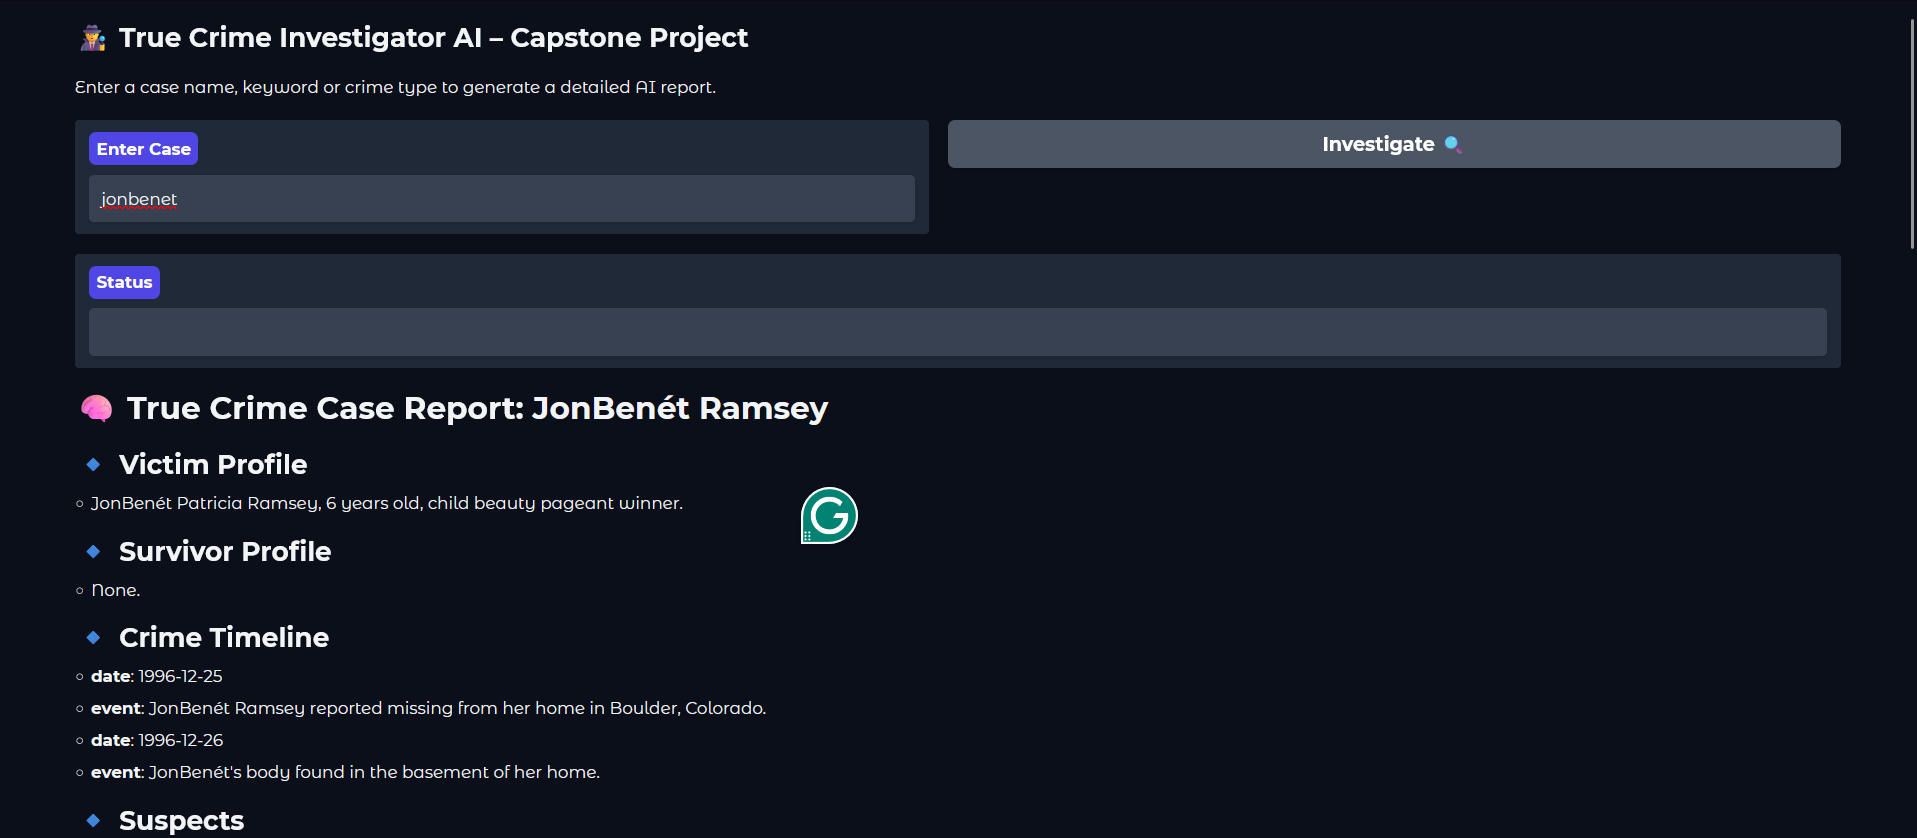
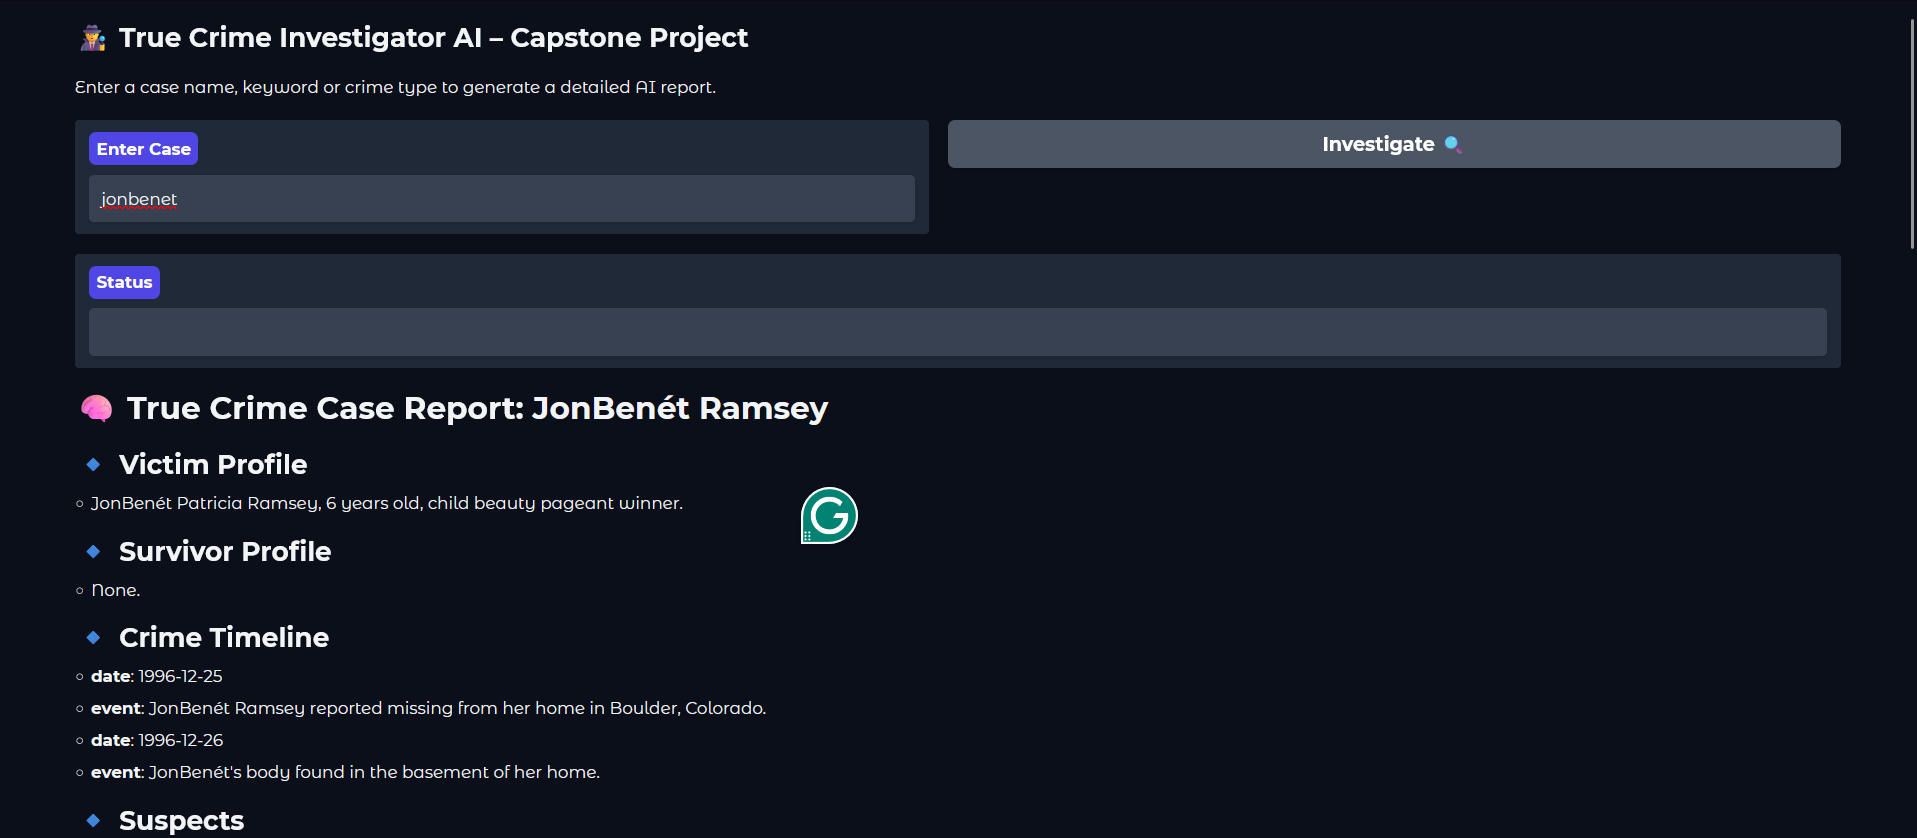